In [1]:
import os
import tqdm
import string
import random
import numpy as np
import pandas as pd
from collections import *
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

In [2]:
### READ DATA ###

df = pd.read_csv('Uber_Ride_Reviews.csv')

print(df.shape)
df.head()

(1344, 3)


,ride_review,ride_rating,sentiment
0,I completed running New York Marathon requeste...,1.0,0
1,My appointment time auto repairs required earl...,1.0,0
2,Whether I using Uber ride service Uber Eats or...,1.0,0
3,Why hard understand I trying retrieve Uber cab...,1.0,0
4,I South Beach FL I staying major hotel ordered...,1.0,0


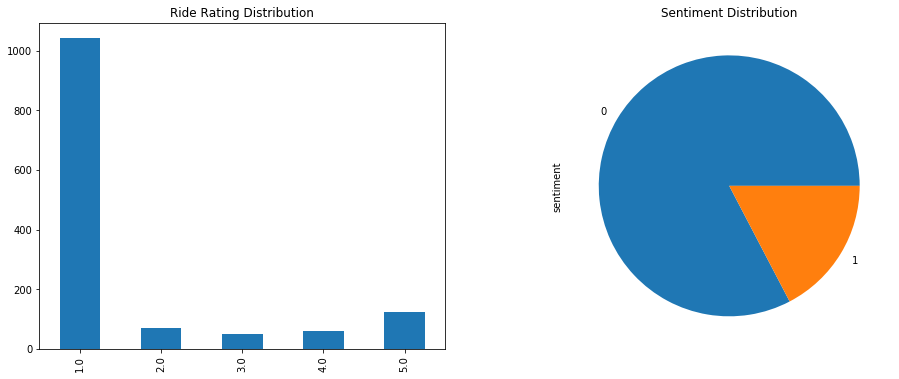

In [3]:
### LABEL DISTRIBUTION ###

plt.figure(figsize=(16,6))

plt.subplot(121)
df.ride_rating.value_counts().sort_index().plot.bar(title='Ride Rating Distribution')

plt.subplot(122)
df.sentiment.value_counts().plot.pie(title='Sentiment Distribution')

In [4]:
### REMOVE 3 STARS REVIEWS ###

df = df.loc[df.ride_rating!=3, :].reset_index(drop=True)

In [5]:
### CLEAN TEXT (NOT REQUIRED) ###

df['text'] = df.ride_review.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ', regex=True)

In [6]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['sentiment'].values, 
                                                    random_state = 42, test_size=0.2)

In [7]:
### CREATE FEATURES WITH TFIDF ###

stop = set(stopwords.words('english'))
tfidf = TfidfVectorizer(min_df=3, stop_words=stop)
tfidf.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [8]:
### REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

c = Counter([len(s.split()) for s in X_train])
lenghts = np.asarray(list(c.keys()))
freq = np.asarray(list(c.values()))
freq = freq/freq.sum()

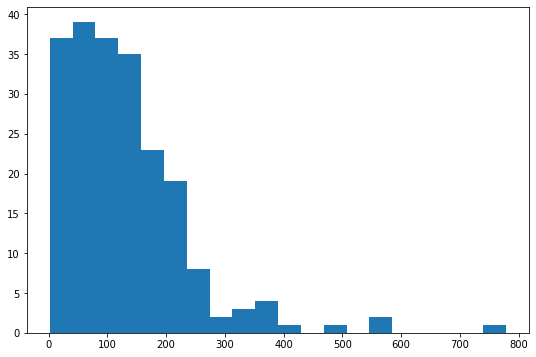

In [9]:
### PLOT REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

plt.figure(figsize=(9,6))
plt.hist(lenghts, bins=20)
np.set_printoptions(False)

In [10]:
### DEFINE MARKOV CHAIN GENERATOR ###

def build_chain(texts):
    
    index = 1
    chain = {}
    
    for text in texts:
        
        text = text.split()
        for word in text[index:]:
            key = text[index-1]
            if key in chain:
                chain[key].append(word)
            else:
                chain[key] = [word]
            index += 1
        
        index = 1
    
    return chain

def create_sentence(chain, lenght, seed):
        
    start = random.choice(list(chain.keys()))
    text = [start]

    while len(text) < lenght:
        try:
            after = random.choice(chain[start])
            start = after
            text.append(after)
        except: #end of the sentence
            #text.append('.')
            start = random.choice(list(chain.keys()))
    
    return ' '.join(text)

def Generator(x_train, y_train, rep, concat=False, seed=33):
    
    random.seed(seed)
    np.random.seed(seed)
    
    new_corpus, new_labels = [], []
    
    for i,lab in enumerate(np.unique(y_train)):

        selected = x_train[y_train == lab]
        chain = build_chain(selected)

        sentences = []
        for i in range(rep):
            lenght = int(np.random.choice(lenghts, 1, p=freq))
            sentences.append(create_sentence(chain, lenght, seed))

        new_corpus.extend(sentences)
        new_labels.extend([lab]*rep)
    
    if concat:
        return np.asarray(list(x_train) + new_corpus), np.asarray(list(y_train) + new_labels)
    
    return np.asarray(new_corpus), np.asarray(new_labels)

In [11]:
### AUGMENT TRAIN DATA ###

X_train_new, y_train_new = Generator(X_train, y_train, rep=300, concat=True, seed=33)

In [12]:
pd.value_counts(y_train_new)

0    1195
1     440
dtype: int64

In [13]:
### CREATE FAKE TEST DATA ###

X_test_new, y_test_new = Generator(X_train, y_train, rep=100, concat=False, seed=42)

In [14]:
pd.value_counts(y_test_new)

0    100
1    100
dtype: int64

In [15]:
### UTILITY FUNCTIONS ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


### NN architecture ###
def NN():
    
    set_seed(33)
    
    nn = Sequential([
              Dense(512, activation='relu', input_shape=(len(tfidf.vocabulary_),)),
              Dropout(0.2),
              Dense(1, activation='sigmoid')])
    
    nn.compile(loss='binary_crossentropy', optimizer='adam')
    
    return nn


### PERFORMANCE REPORT ###
def report_performances(model, y_test, x_test):
    
    x_test = tfidf.transform(x_test).toarray()
    
    if isinstance(model, tf.keras.Model): 
        auc = roc_auc_score(y_test, model.predict(x_test).ravel())
        print('AUC:', auc)
        precision = precision_score(y_test, (model.predict(x_test)>0.5).astype(int), average='macro')
        print('PRECISION:', precision)
        recall = recall_score(y_test, (model.predict(x_test)>0.5).astype(int), average='macro')
        print('RECALL:', recall)
        f1 = f1_score(y_test, (model.predict(x_test)>0.5).astype(int), average='macro')
        print('F1:', f1)
    else: 
        auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
        print('AUC:', auc)
        precision = precision_score(y_test, model.predict(x_test), average='macro')
        print('PRECISION:', precision)
        recall = recall_score(y_test, model.predict(x_test), average='macro')
        print('RECALL:', recall)
        f1 = f1_score(y_test, model.predict(x_test), average='macro')
        print('F1', f1)

# FIT ON ORIGINAL DATA

In [16]:
nn = NN()
nn.fit(tfidf.transform(X_train).toarray(), y_train, batch_size=32, epochs=5, verbose=2)

Epoch 1/5
33/33 - 0s - loss: 0.4671
Epoch 2/5
33/33 - 0s - loss: 0.2898
Epoch 3/5
33/33 - 0s - loss: 0.2144
Epoch 4/5
33/33 - 0s - loss: 0.1418
Epoch 5/5
33/33 - 0s - loss: 0.0788


In [17]:
report_performances(nn, y_test, X_test)

AUC: 0.9108527131782946
PRECISION: 0.8860537951363301
RECALL: 0.7256136950904393
F1: 0.7742692410834005


In [18]:
report_performances(nn, y_test_new, X_test_new)

AUC: 0.9965999999999999
PRECISION: 0.9528985507246377
RECALL: 0.95
F1: 0.9499198717948718


In [19]:
logistic = LogisticRegression(solver='liblinear', random_state=42)
logistic.fit(tfidf.transform(X_train), y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [20]:
report_performances(logistic, y_test, X_test)

AUC: 0.9251722652885442
PRECISION: 0.9285714285714286
RECALL: 0.5813953488372093
F1 0.6015384615384616


In [21]:
report_performances(logistic, y_test_new, X_test_new)

AUC: 0.9912000000000001
PRECISION: 0.7762430939226519
RECALL: 0.595
F1 0.515535751667215


In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(tfidf.transform(X_train), y_train)

RandomForestClassifier(random_state=42)

In [23]:
report_performances(rf, y_test, X_test)

AUC: 0.875484496124031
PRECISION: 0.903061224489796
RECALL: 0.6488479758828596
F1 0.694447615785668


In [24]:
report_performances(rf, y_test_new, X_test_new)

AUC: 0.9489
PRECISION: 0.7628571428571429
RECALL: 0.615
F1 0.552


# FIT ON ORIGINAL + GENERATED DATA

In [25]:
nn = NN()
nn.fit(tfidf.transform(X_train_new).toarray(), y_train_new, batch_size=32, epochs=5, verbose=2)

Epoch 1/5
52/52 - 0s - loss: 0.4787
Epoch 2/5
52/52 - 0s - loss: 0.1525
Epoch 3/5
52/52 - 0s - loss: 0.0565
Epoch 4/5
52/52 - 0s - loss: 0.0274
Epoch 5/5
52/52 - 0s - loss: 0.0157


In [26]:
report_performances(nn, y_test, X_test)

AUC: 0.9238802756244617
PRECISION: 0.8674242424242424
RECALL: 0.7558677863910421
F1: 0.7959794561552762


In [27]:
report_performances(nn, y_test_new, X_test_new)

AUC: 0.9982
PRECISION: 0.975427885096587
RECALL: 0.975
F1: 0.9749943737340901


In [28]:
logistic = LogisticRegression(solver='liblinear', random_state=42)
logistic.fit(tfidf.transform(X_train_new), y_train_new)

LogisticRegression(random_state=42, solver='liblinear')

In [29]:
report_performances(logistic, y_test, X_test)

AUC: 0.9266795865633075
PRECISION: 0.9426229508196722
RECALL: 0.6744186046511628
F1 0.7281859070464767


In [30]:
report_performances(logistic, y_test_new, X_test_new)

AUC: 0.9945999999999999
PRECISION: 0.9027617951668585
RECALL: 0.885
F1 0.8837179908491115


In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(tfidf.transform(X_train_new), y_train_new)

RandomForestClassifier(random_state=42)

In [32]:
report_performances(rf, y_test, X_test)

AUC: 0.883720930232558
PRECISION: 0.8674242424242424
RECALL: 0.7558677863910421
F1 0.7959794561552762


In [33]:
report_performances(rf, y_test_new, X_test_new)

AUC: 0.9805
PRECISION: 0.90625
RECALL: 0.89
F1 0.8888888888888888
